# 🟥 Use Case: 
# Bereich und Format auf Werbebild erkennen
# (Instance Segmentation mit YOLOv11)

In diesem Notebook geht es um ein konkretes Szenario aus der visuellen Bilderkennung

**Wie kann ein YOLO-Instance-Segmentierungsmodell erkennen, ob ein Bild eine rote Werbefläche enthält – und wenn ja, welchem Werbeformat (z. B. F12, F4, Megaposter) diese Fläche zuzuordnen ist?**

## Ziel

Ziel dieses Projekts ist es, mithilfe eines YOLOv11-Modells für Instance Segmentation ein System zu entwickeln, das auf Bildern:
- Rote Werbeflächen erkennt, wie sie typischerweise auf Plakatwänden vorkommen
- Die genaue Position dieser Flächen als Masken segmentiert
- Das zugehörige Format klassifiziert – z. B. als F4, F12, F200, DIG, Megaposter usw.

## Vorgehen
<br>
In den folgenden Kapiteln wird:

##### 1. Ein Datensatz im YOLO-Segmentierungsformat geladen
##### 2. Die Qualität und Struktur der Annotationen überprüft
##### 3. Ein YOLOv11-Instance-Segmentierungsmodell auf diesen Datensatz trainiert
##### 4. Die Leistung des Modells anhand von Kennzahlen und Visualisierungen bewertet
##### 5. Das Modell durch Tuning weiter verbessert (Optional)


## Setup – Installation der benötigten Bibliotheken

Bevor du mit dem eigentlichen Modelltraining, der Datennutzung oder der Vorhersage starten kannst, ist es essenziell, sicherzustellen, dass alle notwendigen Python-Bibliotheken installiert sind. Diese Bibliotheken bilden die Grundlage für alle weiteren Schritte — wie das Laden von Modellen, das Trainieren, Visualisieren und Auswerten von Ergebnissen.

Die nachfolgenden Befehle installieren vier zentrale Pakete, die für deinen Workflow im Bereich Instance Segmentation mit YOLOv11 benötigt werden.
<br>
#### ultralytics
- Dies ist das offizielle Python-Paket für YOLO11, das von den YOLO-Entwicklern gepflegt wird.
- Es enthält:
    * vortrainierte Modelle (z. B. yolo11s-seg.pt)
    * die Trainingslogik
    * Modellinferenz
    * Export-Funktionen (z. B. nach ONNX, TorchScript)
- Ohne diese Bibliothek kannst du weder ein YOLO11-Modell trainieren noch ausführen.
<br>
<br>
#### roboflow
- Roboflow ist ein Dienst zur Verwaltung und Vorbereitung von Datensätzen im Bereich Computer Vision.
- Dieses Paket erlaubt es dir, Datensätze aus der Roboflow-Plattform direkt per API zu laden, anstatt sie manuell herunterzuladen.
- Du kannst so bequem COCO- oder YOLO-formatierte Daten automatisch in deine Umgebung holen.
<br>
<br>
#### opencv-python
- OpenCV ist eine Basisbibliothek für Bildverarbeitung.
- Sie wird benötigt für:
    * Laden und Anzeigen von Bildern (cv2.imread, cv2.imshow)
    * Vorverarbeitung (z. B. Größenänderung, Farbkonvertierung)
    * Darstellung von Bounding Boxes oder Segmentierungen
<br>
<br>
#### supervision
- Supervision ist eine neuere Bibliothek zur Visualisierung von Modellergebnissen.
- Sie stellt High-Level-Funktionen bereit zum Annotieren von:
    * Segmentierungen
    * Masken
    * Klassen-Labels
- Besonders nützlich in Kombination mit YOLO11 + matplotlib, um übersichtliche Ergebnisbilder zu erzeugen.


In [78]:
%pip install ultralytics roboflow opencv-python
%pip install supervision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##  Vorbereitung und Laden des Datensatzes mit Roboflow

In diesem Schritt wird unser annotierter Datensatz direkt aus der Roboflow-Plattform in die aktuelle Arbeitsumgebung geladen. Dazu wird zuerst über die Roboflow-Bibliothek eine Verbindung zur API aufgebaut – mithilfe eines gültigen API-Schlüssels.

Anschliessend wird innerhalb des Workspaces **goldbach-neo-testspace** das Projekt stellenbilder angesprochen. Über version(3) wird gezielt die dritte Version dieses Projekts ausgewählt, welche einen bestimmten Stand des Datensatzes mit Bildern und zugehörigen Annotationen repräsentiert.

Der Datensatz wird im Format **"yolov11"** heruntergeladen – einem Format, das speziell für den Einsatz mit YOLOv11-Modellen optimiert ist. Dabei werden die Bilder und die entsprechenden Labeldateien automatisch lokal gespeichert, typischerweise in einer Ordnerstruktur mit train, valid und test, jeweils mit den passenden .txt-Dateien im YOLO-Format.

Nach Abschluss dieses Schritts stehen die Daten direkt für das Training eines YOLOv11-Instance-Segmentierungsmodells bereit – ohne weiteren manuellen Konvertierungsaufwand.


In [80]:
from roboflow import Roboflow
rf = Roboflow(api_key="qEtrdm1kdiODJEW0dkzq")
project = rf.workspace("goldbach-neo-testspace").project("stellenbilder")
version = project.version(3)
dataset = version.download("yolov11")
                

Note: you may need to restart the kernel to use updated packages.
loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format


Extracting Dataset Version Zip to Stellenbilder-3 in yolov11:: 100%|██████████| 4669/4669 [03:22<00:00, 23.08it/s]


## Dataset prüfen und Samples inkl. Annotationen anzeigen

Dieser Code dient dazu, **ein zufälliges Bild aus einem validierten Datensatz für Instance-Segmentierung im YOLO-Format zu laden und die zugehörigen Segmentierungsannotation visuell darzustellen**. Dabei wird nicht nur das Bild mit seinen Segmentkonturen (Masken) angezeigt, sondern auch die zugehörigen Informationen in der Konsole ausgegeben.

Zunächst werden die relevanten **Verzeichnisse definiert** – das Hauptverzeichnis valid, in dem sich zwei Unterordner befinden: images/ mit den Bilddateien sowie labels/ mit den zugehörigen YOLO-konformen .txt-Annotationen. Anschliessend wird eine Liste aller Bilddateien erstellt und eines davon per Zufall ausgewählt. Dieses Bild wird dann geladen, in das RGB-Farbformat umgewandelt (für die Darstellung mit Matplotlib) und seine Dimensionen (Höhe und Breite) werden gespeichert.

Für das gewählte Bild wird eine **gleichnamige Labeldatei gesucht**, die – falls vorhanden – zeilenweise eingelesen wird. Jede Zeile stellt eine Annotation dar: Der erste Wert beschreibt die Klassen-ID (numerisch), die restlichen Werte repräsentieren die x- und y-Koordinaten eines Polygons, welches die Segmentmaske beschreibt. Diese Koordinaten sind normalisiert (Werte zwischen 0 und 1) und werden mit der Bildbreite und -höhe multipliziert, um sie in absolute Pixelwerte umzuwandeln.

Anschliessend werden die Koordinaten zu einem geschlossenen Polygon verbunden und mit `cv2.polylines()` als Linie auf das Bild gezeichnet. Zusätzlich wird der Klassenname an den ersten Punkt des Polygons geschrieben. In der Konsole wird zu jeder Annotation eine kurze Information ausgegeben, bestehend aus Klassenname, ID und der Anzahl der Polygonpunkte.

Wenn keine passende Labeldatei vorhanden ist, wird eine Warnmeldung ausgegeben. Abschliessend wird das annotierte Bild mit den Segmentmasken in einem Matplotlib-Fenster dargestellt – vollständig ohne Achsen, aber mit einem sprechenden Titel.

Der Code eignet sich hervorragend, um qualitativ zu prüfen, ob die Segmentierungen im Datensatz korrekt zu den Bildern passen und ob die Polygonmasken sinnvoll gesetzt wurden.

Mit folgendem Code kann der Pfad abgefragt werden und für den weiteren Code verwendet werden:


In [48]:
import os
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared



📄 Segment-Annotationen für 51638_jpg.rf.84c3f09d06c8e49b49fd9415b1be69b3.jpg:

  → Klasse: F4 (ID: 5), Punkte: 11


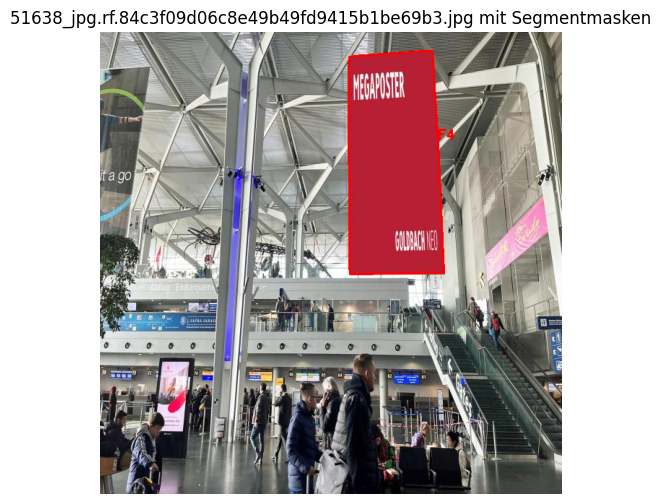

In [11]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Verzeichnisse
base_dir = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Stellenbilder-3/valid"
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Klassenliste
class_names = ['items', 'DIG', 'F12', 'F200', 'F24', 'F4', 'Megaposter']

# Zufälliges Bild auswählen
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
image_file = random.choice(image_files)
image_path = os.path.join(image_dir, image_file)
label_file = os.path.splitext(image_file)[0] + ".txt"
label_path = os.path.join(label_dir, label_file)

# Bild laden
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# Annotationen laden und zeichnen
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        print(f"\n📄 Segment-Annotationen für {image_file}:\n")
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            coords = list(map(float, parts[1:]))

            # Punkte in (x, y) Paaren gruppieren und skalieren
            points = np.array([
                [int(float(x) * w), int(float(y) * h)]
                for x, y in zip(coords[::2], coords[1::2])
            ], dtype=np.int32)

            label_name = class_names[class_id] if class_id < len(class_names) else str(class_id)

            # Maske zeichnen
            cv2.polylines(image_rgb, [points], isClosed=True, color=(255, 0, 0), thickness=2)
            x, y = points[0]
            cv2.putText(image_rgb, label_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

            # Infos ausgeben
            print(f"  → Klasse: {label_name} (ID: {class_id}), Punkte: {len(points)}")

else:
    print(f"⚠️ Keine .txt-Datei gefunden für {image_file}")

# Bild anzeigen
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title(f"{image_file} mit Segmentmasken")
plt.show()


## Modell trainieren

### 1. Modell laden
Zu Beginn wird das vortrainierte YOLOv11-Model yolo11s-seg.pt geladen.
Dieses Modell ist speziell für Segmentierungsaufgaben optimiert – es erkennt nicht nur Objekte über Bounding Boxes, sondern auch über präzise Masken (Polygone).
Das Kürzel **s** steht für eine **kleinere, schnellere Variante („small“)** mit geringerem Rechenaufwand.

### 2. Trainingskonfiguration
Mit model.train() wird der Trainingsprozess gestartet. Dabei werden folgende Parameter gesetzt:

- **data**: Gibt den Pfad zu einer Konfigurationsdatei (data.yaml) an, die Informationen über den verwendeten Datensatz enthält. Dazu zählen unter anderem die Pfade zu Trainings- und Validierungsdaten sowie die Definition der Klassen.

- **epochs**: Legt fest, wie oft das gesamte Trainingsset während des Trainingsprozesses durchlaufen wird. Eine höhere Anzahl bedeutet intensiveres Lernen des Modells.

- **imgsz**: Bestimmt die Bildgrösse, auf die alle Eingabebilder während des Trainings skaliert werden. Dies beeinflusst sowohl den Speicherverbrauch als auch die Trainingsgeschwindigkeit und Modellgenauigkeit.

- **batch**: Definiert die Anzahl der Bilder, die gleichzeitig in einem Schritt durch das Modell geschickt werden. Diese Einstellung wirkt sich direkt auf den Speicherbedarf und die Stabilität des Trainings aus.

- **device**: Gibt an, auf welcher Hardware das Training durchgeführt wird. Übliche Optionen sind CPU oder GPU, je nachdem, welche Rechenressourcen zur Verfügung stehen.

### 3. Trainingsablauf
Sobald der Trainingsprozess beginnt, verarbeitet das Modell die Trainingsbilder, berechnet Verlustfunktionen (Loss), passt seine Gewichte an und lernt so, die definierten Klassen mithilfe von Segmentierungen zu erkennen.
Die Ergebnisse – inklusive Modellgewichten, Logdaten und ggf. Visualisierungen – werden im Standard-Ordner runs/segment/ gespeichert.


In [122]:
from ultralytics import YOLO

# Modell laden
model = YOLO('yolo11s-seg.pt')  # Wähle je nach Bedarf yolov12n, yolov12s, yolov12m, yolov12l oder yolov12x

# Training starten
results = model.train(
    data='/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Stellenbilder-3/data.yaml',  # Pfad zur YAML-Datei deines Datensatzes
    epochs=10,
    imgsz=640,
    batch=3,
    device='cpu'   # Setze auf 'cpu' oder 'cuda' je nach Verfügbarkeit
)

New https://pypi.org/project/ultralytics/8.3.137 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.134 🚀 Python-3.10.16 torch-2.7.0+cu126 CPU (Intel Xeon Platinum 8272CL 2.60GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=3, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Stellenbilder-3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=


'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
       1/10         0G     0.5585     0.6627      1.772     0.8722          4        640: 100%|██████████| 747/747 [58:07<00:00,  4.67s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  92%|█████████▏| 11/12 [00:37<00:03,  3.42s/it]
       2/10         0G     0.5812     0.6389     0.8991     0.8865          6        640: 100%|██████████| 747/747 [56:50<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  92%|█████████▏| 11/12 [00:35<00:03,  3.27s/it]
       3/10         0G     0.557

## Vorhersagen durchführen

Der gezeigte Code dient dazu, die Vorhersagefähigkeit eines zuvor trainierten **YOLO-Instance-Segmentierungsmodells** anhand eines zufällig gewählten Bildes aus dem Validierungsdatensatz visuell zu überprüfen. Dabei wird ein Bild geladen, mit dem Modell segmentiert und anschliessend mit farbigen Masken und Klassenbezeichnungen annotiert dargestellt.

Zunächst wird ein trainiertes YOLO-Segmentierungsmodell über die Ultralytics-Bibliothek geladen – in diesem Fall das beste Modell aus einem früheren Trainingslauf, gespeichert unter dem Pfad `train29/weights/best.pt`. **Dieser Pfad soll angepasst werden auf den eigenen Ordnernamen nach dem Trainieren**. Dieses Modell ist dafür ausgelegt, Objekte in Bildern nicht nur zu lokalisieren, sondern sie mithilfe von Segmentmasken pixelgenau zu erfassen.

Anschliessend wird ein Pfad zum Validierungsbildordner angegeben, aus dem mit der `Path.glob()`-Funktion alle `.jpg`-Dateien gesammelt werden. Daraus wird eines der Bilder per Zufall ausgewählt und mit OpenCV geladen.

Dieses Bild wird dann dem geladenen YOLO-Modell übergeben, um eine Vorhersage durchzuführen. Das Modell liefert dabei neben der Objektklasse auch die Segmentmaske für jedes erkannte Objekt. Die Ergebnisse werden mit der Bibliothek `supervision` verarbeitet, die eine einfache Möglichkeit bietet, Detektionsergebnisse aus dem YOLO-Format zu extrahieren, zu verfeinern (z. B. durch Non-Maximum Suppression) und visuell aufzubereiten.

Zwei spezialisierte Annotatoren – der `MaskAnnotator` für die farbigen Segmentmasken und der `LabelAnnotator` für die Textbeschriftungen – sorgen dafür, dass die Erkennungsergebnisse auf das Originalbild gezeichnet werden. Abschliessend wird das annotierte Bild mithilfe von `matplotlib` dargestellt: segmentierte Objekte sind farblich hervorgehoben, und deren Klassenbezeichnungen sind lesbar eingeblendet. Dies dient der qualitativen Überprüfung, ob das Modell korrekt arbeitet und welche Objekte es auf dem Bild erkannt hat.



0: 640x640 1 F12, 388.3ms
Speed: 2.5ms preprocess, 388.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


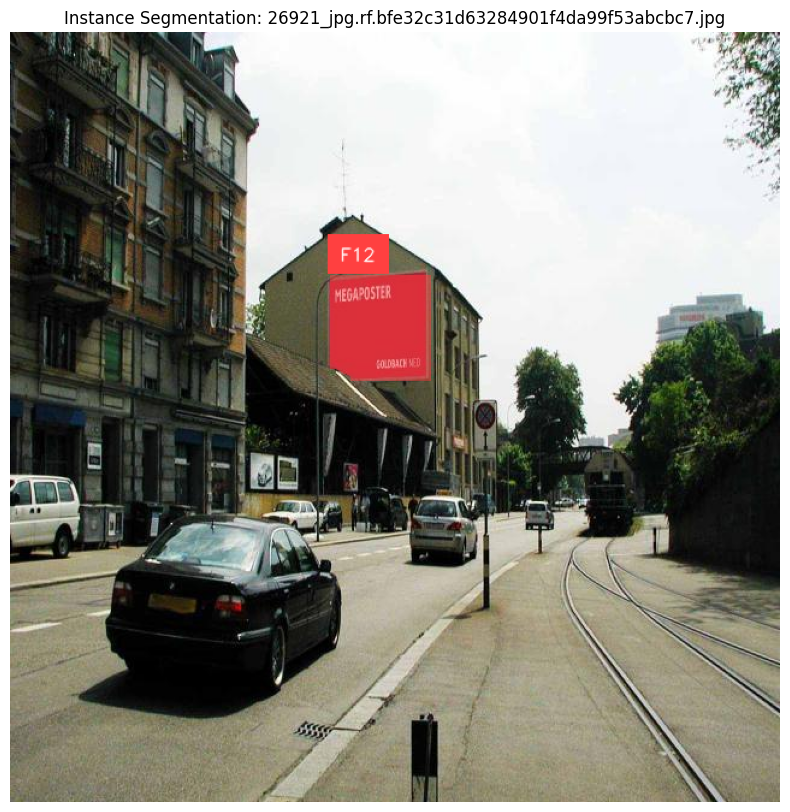

In [7]:
import random
import cv2
import matplotlib.pyplot as plt
from supervision import Detections, MaskAnnotator, LabelAnnotator
from ultralytics import YOLO
from pathlib import Path

# Modell laden (Segmentierungsmodell!)
model = YOLO('/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/runs/segment/train29/weights/best.pt')

# Pfad zum Validierungs-Datensatz
dataset_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/Stellenbilder-3/valid/images'
image_paths = list(Path(dataset_path).glob('*.jpg'))  # ggf. '*.png' je nach Format

# Zufälliges Bild auswählen und laden
image_path = random.choice(image_paths)
image = cv2.imread(str(image_path))

# Vorhersage durchführen
results = model(image)[0]

# Detections aus den Ergebnissen extrahieren (inkl. Masken)
detections = Detections.from_ultralytics(results).with_nms()

# Annotatoren für Masken und Labels
mask_annotator = MaskAnnotator()
label_annotator = LabelAnnotator()

# Annotieren
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# Ergebnis anzeigen
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Instance Segmentation: {image_path.name}")
plt.show()


## Modell evaluieren

Dieser Code dient der Visualisierung der Trainingsauswertungsergebnisse eines YOLO-Segmentierungsmodells, die automatisch von Ultralytics im Verzeichnis `runs/segment/train29` **(Wichtig: Pfad anpassen auf eigenen Ordner mit den Trainingsresultaten!)** erzeugt wurden. Er ermöglicht es, wichtige Metriken und Kurven aus dem Training direkt im Jupyter Notebook übersichtlich anzuzeigen.

Zunächst wird sichergestellt, dass die Diagramme direkt im Notebook angezeigt werden können `(%matplotlib inline)`. Anschliessend wird das Zielverzeichnis definiert, in dem die Trainingsmetriken als PNG-Bilder abgelegt sind – typischerweise nach Abschluss eines YOLO-Trainingslaufs.

Die Datei-Liste image_files enthält die gängigen grafischen Auswertungen, die von Ultralytics automatisch erstellt werden:

- **BoxPR_curve.png**: Precision-Recall-Kurve für Bounding Boxes

- **BoxP_curve.png und BoxR_curve.png**: Precision- und Recall-Verlauf pro Klasse

- **BoxF1_curve.png**: F1-Score-Kurve pro Klasse

- **confusion_matrix.png**: Verwechslungsmatrix (welche Klassen verwechselt wurden)

- **results.png**: Zusammenfassung der wichtigsten Trainingsmetriken über alle Epochen hinweg (z. B. Loss, mAP, Precision)

Für jede dieser Dateien wird geprüft, ob sie vorhanden ist und anschliessend mit matplotlib geöffnet und angezeigt. Dabei werden die Achsen bewusst ausgeblendet, um die Diagramme übersichtlich zu präsentieren. Jeder Plot bekommt ausserdem den Dateinamen als Titel, um ihn leichter identifizieren zu können.

Zusammengefasst ermöglicht dieser Code eine schnelle, visuelle Einsicht in den Trainingsverlauf und die Performance des Modells – ein wichtiger Schritt zur Evaluation und Beurteilung der Modellqualität.


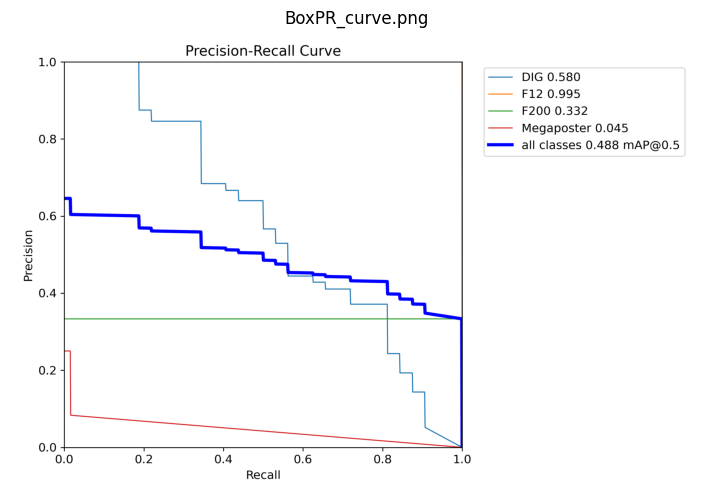

<Figure size 640x480 with 0 Axes>

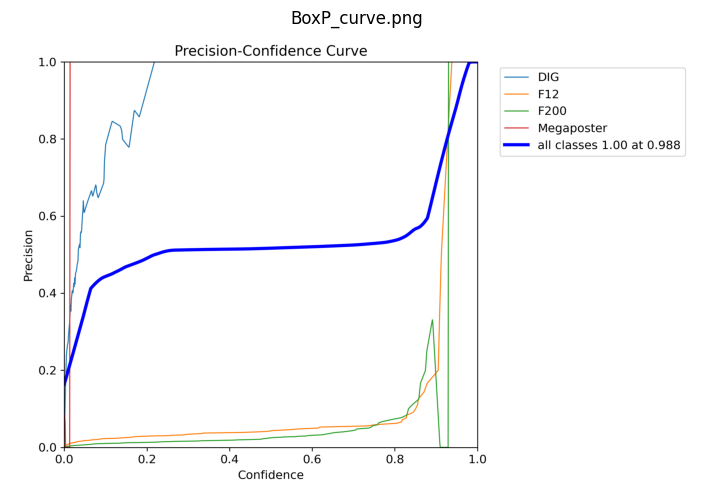

<Figure size 640x480 with 0 Axes>

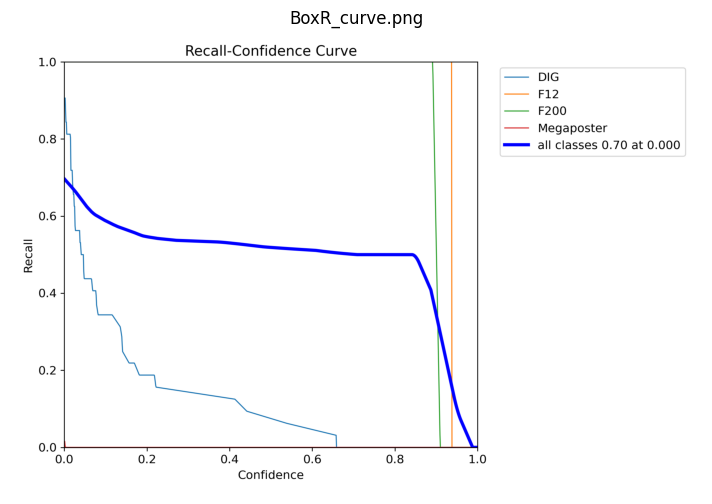

<Figure size 640x480 with 0 Axes>

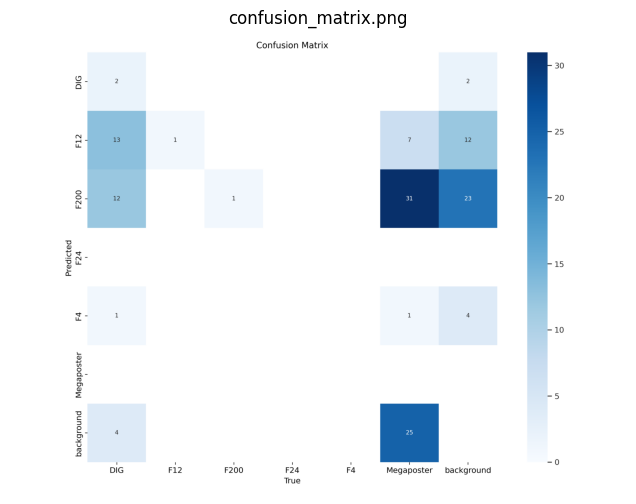

<Figure size 640x480 with 0 Axes>

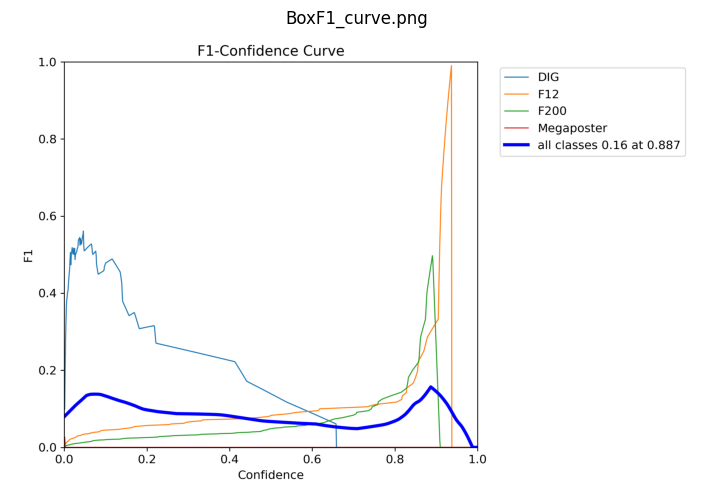

<Figure size 640x480 with 0 Axes>

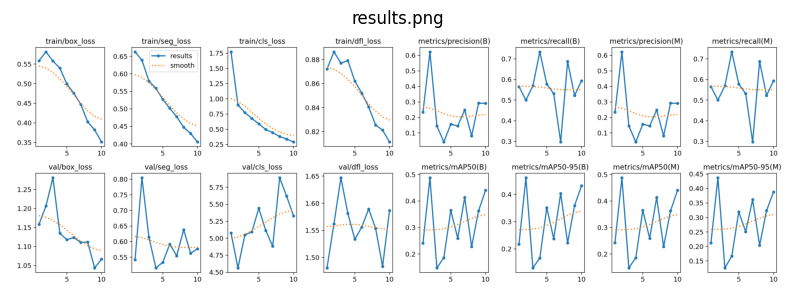

<Figure size 640x480 with 0 Axes>

In [12]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Verzeichnis mit den PNG-Bildern (Anpassen nach jedem neuem Training!)
image_folder = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/adm-amared1/code/Users/adm-amared/runs/segment/train29'

# Liste der Bilddateien
image_files = [
    "BoxPR_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "confusion_matrix.png",
    "BoxF1_curve.png",
    "results.png"
]

# Zeige jedes Bild mit Abstand
for image_file in image_files:
    # Bild laden
    img_path = os.path.join(image_folder, image_file)
    img = mpimg.imread(img_path)

    # Erstelle eine neue Figur mit plt.subplots() und füge das Bild hinzu
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.axis('off')  # Achsen ausblenden
    ax.set_title(image_file)  # Bildname als Titel
    plt.show()  # Bild anzeigen

    # Abstand hinzufügen zwischen den Bildern
    plt.subplots_adjust(hspace=0.5)  # hspace fügt vertikalen Abstand hinzu


### Precision Curve

**Definition**:  
Die **Precision Curve** zeigt, wie sich die Precision eines Klassifikators in Abhängigkeit von der Konfidenz des Modells verändert. Der Schwellenwert des Modells beeinflusst, wie sicher das Modell sein muss, um eine positive Klassifikation zu treffen.  

**Precision**:  
Precision ist der Anteil der korrekt identifizierten positiven Vorhersagen an allen Vorhersagen, die als positiv klassifiziert wurden.  

**Interpretation**:  
Ein hoher Wert auf der Precision-Kurve bedeutet, dass das Modell eine hohe Präzision bei seinen positiven Vorhersagen hat und nur wenige falsch-positive Vorhersagen macht.

<br>
<br>


### Recall Curve

**Definition**:  
Die **Recall Curve** zeigt, wie sich der Recall eines Klassifikators bei verschiedenen Schwellenwerten verändert. Recall misst den Anteil der tatsächlichen positiven Instanzen, die korrekt vom Modell erkannt wurden.  

**Recall**:  
Recall ist der Anteil der positiven Instanzen, die das Modell korrekt identifiziert hat, aus allen tatsächlich positiven Instanzen.  

**Interpretation**:  
Ein hoher Wert auf der Recall-Kurve bedeutet, dass das Modell viele der tatsächlichen positiven Instanzen korrekt identifiziert, jedoch könnte auch eine höhere Anzahl an falsch-positiven Vorhersagen produziert werden.

<br>
<br>

### Confusion Matrix (Verwirrungsmatrix)

**Definition**:  
Die **Confusion Matrix** zeigt die Leistung eines Klassifikators und gibt an, wie oft jede Klasse korrekt oder falsch klassifiziert wurde.  

**Werte der Matrix**:  
- **True Positives (TP)**: Richtig positiv klassifizierte Instanzen.  
- **False Positives (FP)**: Fälschlicherweise als positiv klassifizierte Instanzen.  
- **True Negatives (TN)**: Richtig negativ klassifizierte Instanzen.  
- **False Negatives (FN)**: Fälschlicherweise als negativ klassifizierte Instanzen.  

**Interpretation**:  
Eine gute Confusion Matrix zeigt hohe Werte in den Zellen für True Positives und True Negatives, was bedeutet, dass das Modell viele Instanzen korrekt klassifiziert hat.

<br>
<br>


### F1 Score Curve

**Definition**:  
Der **F1-Score** ist das harmonische Mittel von Precision und Recall und hilft dabei, ein ausgewogenes Maß für die Leistung eines Modells zu berechnen.  

**F1-Score**:  
Der F1-Score kombiniert die Precision und den Recall eines Modells und ist besonders nützlich, wenn eine Balance zwischen diesen beiden Metriken gewünscht wird.  

**Interpretation**:  
Ein hoher F1-Score bedeutet, dass das Modell sowohl eine hohe Präzision als auch einen hohen Recall aufweist. Dies zeigt, dass das Modell keine großen Kompromisse bei einer der beiden Metriken eingeht.

<br>
<br>

### Precision-Recall Curve (PR Curve)

**Definition**:  
Die **Precision-Recall Curve** zeigt das Verhältnis zwischen Precision (Präzision) und Recall (Sensitivität) des Klassifikators bei verschiedenen Schwellenwerten.  

**Precision**:  
Precision ist der Anteil der korrekt identifizierten positiven Vorhersagen an allen Vorhersagen, die das Modell als positiv klassifiziert hat.  

**Recall**:  
Recall ist der Anteil der tatsächlich positiven Instanzen, die korrekt vom Modell erkannt wurden.  

**Interpretation**:  
Eine gute PR-Kurve zeigt, dass das Modell sowohl eine hohe Precision als auch einen hohen Recall erreicht. Wenn der Bereich unter der Kurve groß ist, bedeutet das ein gutes Modell.

<br>
<br>

### Mean Average Precision (mAP)

Bei Instance Segmentation bewertet mAP gleichzeitig zwei Dinge:

1. Ob das Modell das richtige Objekt erkennt (Klassifikation)

1. Ob die vorhergesagte Maske (Form und Position) dem Ground Truth nahekommt (Segmentierungsgenauigkeit)

Das geschieht über die Berechnung von:

- IoU (Intersection over Union) zwischen der vorhergesagten Maske und der tatsächlichen Maske

- Precision & Recall bei verschiedenen IoU-Schwellen (z. B. 0.5, 0.75)

Dann wird daraus Average Precision (AP) pro Klasse berechnet – und über alle Klassen gemittelt ergibt sich mAP

| mAP-Wert        | Bedeutung (grob)                                                                             |
| --------------- | -------------------------------------------------------------------------------------------- |
| **> 0.80**      | Exzellente Segmentierung & Erkennung                                                         |
| **0.60 – 0.80** | Gutes Modell, ggf. noch Optimierungspotenzial                                                |
| **< 0.60**      | Mäßige bis schlechte Leistung → Datensatz prüfen, Architektur oder Hyperparameter verbessern |

<br>
<br>

#### Intersection over Union (IoU): 

Misst die räumliche Überlappung zwischen einer vorhergesagten Bounding Box und einer Ground Truth Bounding Box. Während IoU die Lokalisierungsqualität für einzelne Erkennungen bewertet, verwendet mAP IoU-Schwellenwerte (z. B. 0,5 oder die Spanne 0,5:0,95), um zu bestimmen, ob eine Erkennung als "true positive" gilt, und fasst dann die Leistung über Klassen und Konfidenzstufen hinweg zusammen. IoU selbst ist eine Komponente der mAP-Berechnung und kein Ersatz dafür.


## Hyperparameter-Tuning

Für eine feinere Anpassung deines Modells kannst du Hyperparameter wie Lernrate, Anzahl der Epochen und Batch-Grösse und sehr viele weitere Parameter anpassen. Nachfolgend wird in der Tabelle angezeigt welche Möglichkeiten für das Hyperparamter-Tuning bestehen sowie ein Beispielcode:

| Argument   | Typ            | Standard | Beschreibung |
|------------|----------------|----------|--------------|
| `model`    | `str`          | `None`   | Gibt die Modelldatei für das Training an. Akzeptiert einen Pfad zu entweder einer `.pt` vortrainiertes Modell oder eine `.yaml` Konfigurationsdatei. Unerlässlich für die Definition der Modellstruktur oder die Initialisierung von Gewichten. |
| `data`     | `str`          | `None`   | Pfad zur Konfigurationsdatei des Datensatzes (z. B. `coco8.yaml`). Enthält Pfade zu Trainings- und Validierungsdaten, Klassennamen und Anzahl der Klassen. |
| `epochs`   | `int`          | `100`    | Gesamtzahl der Trainingsepochen. Jede Epoche stellt einen vollständigen Durchlauf durch den Datensatz dar. Anpassung dieses Wertes beeinflusst Dauer und Leistung. |
| `time`     | `float`        | `None`   | Maximale Trainingszeit in Stunden. Überschreibt `epochs`-Wert. Automatischer Abbruch nach angegebener Dauer, z. B. bei begrenzten Ressourcen. |
| `patience` | `int`          | `100`    | Anzahl Epochen ohne Validierungsverbesserung, bevor das Training gestoppt wird. Verhindert Überanpassung. |
| `batch`    | `int`          | `16`     | Batch-Größe. Drei Modi: fester Wert (z. B. `16`), `-1` für automatische GPU-Auslastung oder z. B. `0.70` für 70 %-Nutzung. |
| `imgsz`    | `int or list`  | `640`    | Zielbildgröße, auf die alle Trainingsbilder skaliert werden. Beeinflusst Genauigkeit und Rechenaufwand. |
| `save`     | `bool`         | `True`   | Speichert Kontrollpunkte und finale Gewichte. Nützlich für Wiederaufnahme und Deployment. |
| `save_period` | `int`       | `-1`     | Speichert Modell alle `n` Epochen. `-1` deaktiviert periodisches Speichern. |
| `cache`    | `bool`         | `False`  | Zwischenspeicherung von Bildern im RAM (`True`), auf Disk (`'disk'`) oder deaktiviert (`False`). Beschleunigt Training, benötigt aber Speicher. |
| `device`       | `int / str / list` | `None`   | Gibt das Rechengerät an: einzelne GPU (`0`), mehrere GPUs (`[0,1]`), CPU (`'cpu'`), Apple MPS (`'mps'`) oder automatisch (`-1`/`[-1,-1]`). |
| `workers`      | `int`              | `8`      | Anzahl der Threads für Datenladen pro Prozess. Erhöht Datenvorverarbeitungsgeschwindigkeit. |
| `project`      | `str`              | `None`   | Name des Projektverzeichnisses für Trainingsergebnisse. |
| `name`         | `str`              | `None`   | Name des Trainingslaufs. Erstellt Unterverzeichnis im Projektordner. |
| `exist_ok`     | `bool`             | `False`  | Überschreibt bestehende Projektnamenverzeichnisse, wenn `True`. |
| `pretrained`   | `bool or str`      | `True`   | Startet mit vortrainiertem Modell (`True`) oder spezifischem Pfad (`str`). |
| `optimizer`    | `str`              | `'auto'` | Optimierungsalgorithmus: `SGD`, `Adam`, `AdamW`, etc. oder `auto` für automatische Auswahl. |
| `seed`         | `int`              | `0`      | Zufalls-Seed für reproduzierbare Ergebnisse. |
| `deterministic`| `bool`             | `True`   | Erzwingt deterministisches Verhalten. Reduziert Varianz, evtl. langsamer. |
| `single_cls`   | `bool`             | `False`  | Behandelt alle Klassen als eine. Für binäre Klassifikation nützlich. |
| `classes`      | `list[int]`        | `None`   | Liste von Klassen-IDs, auf die trainiert werden soll. |
| `rect`         | `bool`             | `False`  | Rechteckiges Training zur Minimierung von Padding. |
| `multi_scale`  | `bool`             | `False`  | Ändert `imgsz` beim Training dynamisch. Fördert Modellrobustheit. |
| `cos_lr`       | `bool`             | `False`  | Nutzt Cosine-LR-Scheduler zur Lernratenanpassung über die Zeit. |
| `close_mosaic` | `int`              | `10`     | Deaktiviert Mosaic-Augmentation in den letzten `N` Epochen. Stabilisiert das Training. |
| `resume`       | `bool`             | `False`  | Nimmt Training aus letztem Checkpoint wieder auf. |
| `amp`          | `bool`             | `True`   | Aktiviert automatisches Mixed-Precision-Training für Effizienz. |
| `fraction`     | `float`            | `1.0`    | Prozentualer Anteil des Datensatzes, der verwendet wird. |
| `profile`      | `bool`             | `False`  | Erstellt ONNX- und TensorRT-Profile zur Laufzeit. |
| `freeze`       | `int or list`      | `None`   | Friert erste `n` Schichten oder Schichten per Index ein. Für Transfer Learning nützlich. |
| `lr0`            | `float`        | `0.01`   | Anfangslernrate (z. B. `1E-2` für SGD, `1E-3` für Adam). Kritisch für Lernverhalten. |
| `lrf`            | `float`        | `0.01`   | Endlernrate als Bruchteil von `lr0` (z. B. `lr0 * lrf`). |
| `momentum`       | `float`        | `0.937`  | Momentum für SGD bzw. `beta1` für Adam. Steuert Gradientenverlauf. |
| `weight_decay`   | `float`        | `0.0005` | L2-Regularisierung. Verhindert Überanpassung durch Bestrafung großer Gewichte. |
| `warmup_epochs`  | `float`        | `3.0`    | Anzahl Aufwärm-Epochen für die Lernrate. |
| `warmup_momentum`| `float`        | `0.8`    | Anfangs-Momentum in der Aufwärmphase. Passt sich schrittweise an. |
| `warmup_bias_lr` | `float`        | `0.1`    | Lernrate für Bias-Parameter während Aufwärmphase. |
| `box`            | `float`        | `7.5`    | Gewichtung des Box-Verlusts bei der Gesamtverlustberechnung. |
| `cls`            | `float`        | `0.5`    | Gewichtung des Klassifizierungsverlusts. |
| `dfl`            | `float`        | `1.5`    | Gewichtung des Distribution Focal Loss (DFL). |
| `pose`           | `float`        | `12.0`   | Gewichtung des Pose-Verlusts (für Keypoints). |
| `kobj`           | `float`        | `2.0`    | Gewichtung des Objektivitätsverlusts bei Keypoints. |
| `nbs`            | `int`          | `64`     | Nominale Batchgröße zur Normalisierung des Verlusts. |
| `overlap_mask`   | `bool`         | `True`   | Bestimmt, ob sich Masken überlappen dürfen. |
| `mask_ratio`     | `int`          | `4`      | Downsample-Verhältnis bei Segmentierungsmasken. |
| `dropout`        | `float`        | `0.0`    | Dropout-Rate zur Regularisierung bei Klassifikation. |
| `val`            | `bool`         | `True`   | Aktiviert Validierung während des Trainings. |
| `plots`          | `bool`         | `False`  | Erstellt Trainingsdiagramme und Vorhersagebeispiele. |


In [ ]:
results = model.train(
    data='/content/advertising-banner-finder-3/data.yaml',
    epochs=500,
    imgsz=640,
    batch=32,
    lr0=0.01,  # Lernrate
    lrf=0.01,  # Lernraten-Faktor
    momentum=0.937,
    weight_decay=0.0005,
    device='cpu'
)

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/advertising-banner-finder-3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/runs/detect/train4/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, p

train: Scanning /content/advertising-banner-finder-3/train/labels.cache... 36 images, 1 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1242.0±309.5 MB/s, size: 61.8 KB)



val: Scanning /content/advertising-banner-finder-3/valid/labels.cache... 10 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 11. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 